In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!pip install geopy
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

! pip install folium==0.5.0  #!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [2]:
CLIENT_ID = 'UMK1FOR1YRVMBC1FQV1EB2EMI5FK2JFX55N1TYGXMH55SAQZ' # your Foursquare ID
CLIENT_SECRET = 'I1HUD3POY15G2ZO1LVKVPWTOQY5JR0WPMQ4OLLDTUQQ05L4N' # your Foursquare Secret
ACCESS_TOKEN = 'NJXWTXNKA25V0XKL2FFTCEM5IXH0N04EWVVSZNHRH5KDI1VX' # your FourSquare Access Token
VERSION = '20210619'
LIMIT = 50
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: UMK1FOR1YRVMBC1FQV1EB2EMI5FK2JFX55N1TYGXMH55SAQZ
CLIENT_SECRET:I1HUD3POY15G2ZO1LVKVPWTOQY5JR0WPMQ4OLLDTUQQ05L4N


In [3]:
#New Yor City Popularity Analysis

address = 'New York City, NY'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

40.7127281 -74.0060152


In [4]:
search_query = '1' #'sortByPopularity'
radius = 10000
print(search_query + ' .... OK!')

1 .... OK!


In [5]:
url_ny = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&sortByPopularity={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude,ACCESS_TOKEN, VERSION, search_query, radius, LIMIT)
url_ny


'https://api.foursquare.com/v2/venues/explore?client_id=UMK1FOR1YRVMBC1FQV1EB2EMI5FK2JFX55N1TYGXMH55SAQZ&client_secret=I1HUD3POY15G2ZO1LVKVPWTOQY5JR0WPMQ4OLLDTUQQ05L4N&ll=40.7127281,-74.0060152&oauth_token=NJXWTXNKA25V0XKL2FFTCEM5IXH0N04EWVVSZNHRH5KDI1VX&v=20210619&sortByPopularity=1&radius=10000&limit=50'

In [6]:
results_ny = requests.get(url_ny).json()

In [7]:
# assign relevant part of JSON to venues
ny_venues= results_ny['response']['groups'][0]['items']

# tranform venues into a dataframe
dataframe_ny = json_normalize(ny_venues)


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  """


In [8]:
# keep only columns that include venue name, and anything that is associated with location

filtered_columns_ny =  ['venue.name', 'venue.categories'] + [col for col in dataframe_ny.columns if col.startswith('venue.location.')] + ['venue.id']
dataframe_filtered_ny = dataframe_ny.loc[:, filtered_columns_ny]


# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered_ny['venue.categories'] = dataframe_filtered_ny.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered_ny.columns = [column.split('.')[-1] for column in dataframe_filtered_ny.columns]

#dataframe_filtered_ny.head()

In [9]:
dataframe_filtered_ny[["name","categories","lat","lng","distance","city"]].head()

,name,categories,lat,lng,distance,city
0,Prospect Park,Park,40.661938,-73.969617,6434,Brooklyn
1,Central Park,Park,40.783076,-73.965497,8544,New York
2,Brooklyn Bridge,Bridge,40.705967,-73.996707,1087,New York
3,Bryant Park,Park,40.753621,-73.983265,4940,New York
4,Hudson River Park,Park,40.733747,-74.010425,2369,New York


In [10]:
venues_map_ny = folium.Map(location=[latitude, longitude], zoom_start=12) # generate map centred around the Conrad Hotel

# add a red circle marker to represent the New York City
folium.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup='New York City',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map_ny)

# add the Italian restaurants as blue circle markers
for lat, lng, label in zip(dataframe_filtered_ny['lat'], dataframe_filtered_ny['lng'], dataframe_filtered_ny['categories']):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map_ny)

# display map
venues_map_ny

In [11]:
#Clustering of the Popular places in New York City
neighborhood_ny_clusters=dataframe_filtered_ny[['lat','lng','postalCode']] #Create a new dataframe to which cluster labels will be added
neighborhood_clusters = 4
neighborhood_ny_clustering = neighborhood_ny_clusters[['lat','lng']]
kmeans_ny = KMeans(n_clusters = neighborhood_clusters, random_state = 0).fit(neighborhood_ny_clustering)
cluster_labels= kmeans_ny.labels_

neighborhood_ny_clusters['Cluster Label']=cluster_labels #Add cluster label column to the main dataframe

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [12]:
# create map of neighborhood clusters in New York City

# set color scheme for different clusters
x = np.arange(neighborhood_clusters)
ys = [i + x + (i*x)**2 for i in range(neighborhood_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map for different clusters

markers_colors = []
for lat, lon, poi, cluster in zip(neighborhood_ny_clusters['lat'], neighborhood_ny_clusters['lng'], neighborhood_ny_clusters['postalCode'], neighborhood_ny_clusters['Cluster Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(venues_map_ny)
       
venues_map_ny

In [13]:
from sklearn.metrics import silhouette_score
score=silhouette_score(neighborhood_ny_clustering, kmeans_ny.labels_)
score

0.387385653844799

In [14]:
distance_ny=kmeans_ny.cluster_centers_
distance_ny_list=distance_ny.tolist()

In [15]:
!pip install haversine

In [16]:
from haversine import haversine

dist=0
for i in range(0,3):
    for j in range(0,3):
        dist= dist+haversine(distance_ny_list[i],distance_ny_list[j])**2
      #  print(dist)
#print(dist)             
mean_cluster_dist_ny = dist/8
print(mean_cluster_dist_ny)

39.524658174022264


In [17]:
print(dataframe_filtered_ny['categories'].unique())

#Define buckets for venue categories
scenic=['Bridge', 'Art Museum', 'Memorial Site','Reservoir', 'Scenic Lookout','Pier','Music Venue','Waterfront','Field']
entertainment=['Performing Arts Venue','Fountain','Music Venue']
park=['Park','Botanical Garden','State / Provincial Park','Trail']
necessities=['Farmers Market','Plaza','Grocery Store','Church','Bookstore','Bakery','Gym', 'Climbing Gym']

['Park' 'Bridge' 'Art Museum' 'Memorial Site' 'Farmers Market' 'Reservoir'
 'Scenic Lookout' 'Plaza' 'Performing Arts Venue' 'Botanical Garden'
 'Fountain' 'Pier' 'Grocery Store' 'State / Provincial Park' 'Church'
 'Music Venue' 'Waterfront' 'Bookstore' 'Bakery' 'Gym' 'Climbing Gym'
 'Field' 'Trail']


In [18]:
#necessities=10
#entertainment=9
#park=8
#scenic=7

for i in scenic[:]:
    for j in range(len(dataframe_filtered_ny)):
        if dataframe_filtered_ny.loc[j,'categories']==i:
            dataframe_filtered_ny.loc[j,'score']=7
for i in park[:]:
    for j in range(len(dataframe_filtered_ny)):
        if dataframe_filtered_ny.loc[j,'categories']==i:
            dataframe_filtered_ny.loc[j,'score']=8             
for i in entertainment[:]:
    for j in range(len(dataframe_filtered_ny)):
        if dataframe_filtered_ny.loc[j,'categories']==i:
            dataframe_filtered_ny.loc[j,'score']=9 
            
for i in necessities[:]:
    for j in range(len(dataframe_filtered_ny)):
        if dataframe_filtered_ny.loc[j,'categories']==i:
            dataframe_filtered_ny.loc[j,'score']=10                   

In [19]:
dataframe_filtered_ny[["name","categories","lat","lng","distance","score","city"]].head()

,name,categories,lat,lng,distance,score,city
0,Prospect Park,Park,40.661938,-73.969617,6434,8.0,Brooklyn
1,Central Park,Park,40.783076,-73.965497,8544,8.0,New York
2,Brooklyn Bridge,Bridge,40.705967,-73.996707,1087,7.0,New York
3,Bryant Park,Park,40.753621,-73.983265,4940,8.0,New York
4,Hudson River Park,Park,40.733747,-74.010425,2369,8.0,New York


([<matplotlib.axis.YTick at 0x7f2da51d14e0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

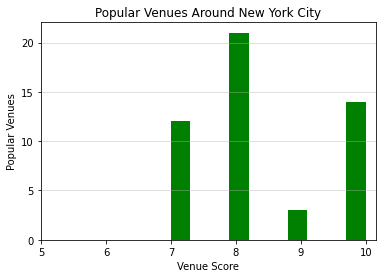

In [20]:
plt.hist(dataframe_filtered_ny['score'],color="g")
plt.xlabel('Venue Score')
plt.ylabel('Popular Venues')
plt.title('Popular Venues Around New York City')
plt.grid(axis='y',alpha=0.5)
plt.xticks(np.arange(5,11,1))
plt.yticks(np.arange(0,25,5))

In [21]:
pop_score_ny=0
for i in range(1,len(dataframe_filtered_ny)):
    pop_score_ny = pop_score_ny + (dataframe_filtered_ny.loc[i,'score'])/haversine((latitude, longitude),(dataframe_filtered_ny.loc[i,'lat'],dataframe_filtered_ny.loc[i,'lng']))
print('Popularity Score for New York City is:',pop_score_ny)

Popularity Score for New York City is: 135.94871838592218


In [22]:
# Popularity clustering for Toronto
address = 'Toronto,ON'

geolocator = Nominatim(user_agent="foursquare_agent")
location1 = geolocator.geocode(address)
latitude1 = location1.latitude
longitude1 = location1.longitude
print(latitude1, longitude1)


43.6534817 -79.3839347


In [23]:
url_to = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&sortByPopularity={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude1, longitude1,ACCESS_TOKEN, VERSION, search_query, radius, LIMIT)
url_to


'https://api.foursquare.com/v2/venues/explore?client_id=UMK1FOR1YRVMBC1FQV1EB2EMI5FK2JFX55N1TYGXMH55SAQZ&client_secret=I1HUD3POY15G2ZO1LVKVPWTOQY5JR0WPMQ4OLLDTUQQ05L4N&ll=43.6534817,-79.3839347&oauth_token=NJXWTXNKA25V0XKL2FFTCEM5IXH0N04EWVVSZNHRH5KDI1VX&v=20210619&sortByPopularity=1&radius=10000&limit=50'

In [24]:
results_to = requests.get(url_to).json()

In [25]:
# assign relevant part of JSON to venues
to_venues= results_to['response']['groups'][0]['items']

# tranform venues into a dataframe
dataframe_to = json_normalize(to_venues)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  """


In [26]:
# keep only columns that include venue name, and anything that is associated with location

filtered_columns_to =  ['venue.name', 'venue.categories'] + [col for col in dataframe_to.columns if col.startswith('venue.location.')] + ['venue.id']
dataframe_filtered_to = dataframe_to.loc[:, filtered_columns_to]


# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered_to['venue.categories'] = dataframe_filtered_to.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered_to.columns = [column.split('.')[-1] for column in dataframe_filtered_to.columns]

#dataframe_filtered_to.head()

In [27]:
dataframe_filtered_to[["name","categories","lat","lng","distance","city"]].head()

,name,categories,lat,lng,distance,city
0,High Park,Park,43.646479,-79.463425,6449,Toronto
1,Woodbine Beach,Beach,43.663112,-79.306374,6337,Toronto
2,Humber Bay Park,Park,43.622396,-79.478389,8359,Toronto
3,Taylor Creek Park,Park,43.696599,-79.306693,7855,Toronto
4,The Distillery Historic District,Historic Site,43.650244,-79.359323,2014,Toronto


In [28]:
venues_map_to = folium.Map(location=[latitude1, longitude1], zoom_start=12) # generate map centred around the Conrad Hotel

# add a red circle marker to represent the New York City
folium.CircleMarker(
    [latitude1, longitude1],
    radius=10,
    color='red',
    popup='Toronto',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map_to)

# add the Italian restaurants as blue circle markers
for lat, lng, label in zip(dataframe_filtered_to['lat'], dataframe_filtered_to['lng'], dataframe_filtered_to['categories']):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map_to)

# display map
venues_map_to

In [29]:
#Clustering of the Popular places in Toronto
neighborhood_to_clusters=dataframe_filtered_to[['lat','lng','postalCode']] #Create a new dataframe to which cluster labels will be added
neighborhood_clusters = 4
neighborhood_to_clustering = neighborhood_to_clusters[['lat','lng']]
kmeans_to = KMeans(n_clusters = neighborhood_clusters, random_state = 0).fit(neighborhood_to_clustering)
cluster_labels= kmeans_to.labels_

neighborhood_to_clusters['Cluster Label']=cluster_labels #Add cluster label column to the main dataframe

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [30]:
# create map of neighborhood clusters in Toronto

# set color scheme for different clusters
x = np.arange(neighborhood_clusters)
ys = [i + x + (i*x)**2 for i in range(neighborhood_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map for different clusters

markers_colors = []
for lat, lon, poi, cluster in zip(neighborhood_to_clusters['lat'], neighborhood_to_clusters['lng'], neighborhood_to_clusters['postalCode'], neighborhood_to_clusters['Cluster Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(venues_map_to)
       
venues_map_to

In [31]:
from sklearn.metrics import silhouette_score
score=silhouette_score(neighborhood_to_clustering, kmeans_to.labels_)
score

0.45204371156436607

In [32]:
distance_to=kmeans_to.cluster_centers_
distance_to_list=distance_to.tolist()

dist=0
for i in range(0,3):
    for j in range(0,3):
        dist= dist+haversine(distance_to_list[i],distance_to_list[j])**2
       # print(dist)     

#print(dist)        
mean_cluster_dist_to = dist/8
print(mean_cluster_dist_to)

38.20798176940305


In [33]:
print(dataframe_filtered_to['categories'].unique())

#Define buckets for venue categories
scenic=['Bridge','Beach', 'Historic Site','Bridge', 'Scenic Lookout','Lake','Field','Harbor / Marina']
entertainment=['Performing Arts Venue','Other Great Outdoors','Liquor Store', 'Brewery','Event Space']
park=['Park','Garden','Trail','Dog Run']
necessities=['Farmers Market','Café','Bakery','Grocery Store','Ice Cream Shop','Deli / Bodega','Coffee Shop']


['Park' 'Beach' 'Historic Site' 'Farmers Market' 'Other Great Outdoors'
 'Garden' 'Trail' 'Liquor Store' 'Café' 'Performing Arts Venue' 'Field'
 'Bakery' 'Brewery' 'Grocery Store' 'Lake' 'Scenic Lookout'
 'Ice Cream Shop' 'Dog Run' 'Event Space' 'Bridge' 'Deli / Bodega'
 'Harbor / Marina' 'Coffee Shop']


In [34]:
#necessities=10
#entertainment=9
#park=8
#scenic=7

for i in scenic[:]:
    for j in range(len(dataframe_filtered_to)):
        if dataframe_filtered_to.loc[j,'categories']==i:
            dataframe_filtered_to.loc[j,'score']=7
for i in park[:]:
    for j in range(len(dataframe_filtered_to)):
        if dataframe_filtered_to.loc[j,'categories']==i:
            dataframe_filtered_to.loc[j,'score']=8             
for i in entertainment[:]:
    for j in range(len(dataframe_filtered_to)):
        if dataframe_filtered_to.loc[j,'categories']==i:
            dataframe_filtered_to.loc[j,'score']=9 
            
for i in necessities[:]:
    for j in range(len(dataframe_filtered_to)):
        if dataframe_filtered_to.loc[j,'categories']==i:
            dataframe_filtered_to.loc[j,'score']=10
           

In [35]:
dataframe_filtered_to[["name","categories","lat","lng","distance","score","city"]].head()

,name,categories,lat,lng,distance,score,city
0,High Park,Park,43.646479,-79.463425,6449,8.0,Toronto
1,Woodbine Beach,Beach,43.663112,-79.306374,6337,7.0,Toronto
2,Humber Bay Park,Park,43.622396,-79.478389,8359,8.0,Toronto
3,Taylor Creek Park,Park,43.696599,-79.306693,7855,8.0,Toronto
4,The Distillery Historic District,Historic Site,43.650244,-79.359323,2014,7.0,Toronto


([<matplotlib.axis.YTick at 0x7f2da4df5a58>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

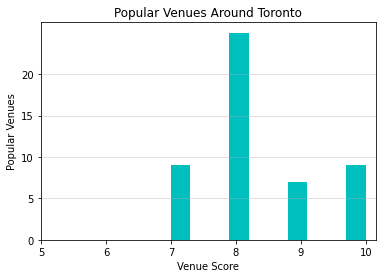

In [36]:
plt.hist(dataframe_filtered_to['score'],color="c")
plt.xlabel('Venue Score')
plt.ylabel('Popular Venues')
plt.title('Popular Venues Around Toronto')
plt.grid(axis='y',alpha=0.5)
plt.xticks(np.arange(5,11,1))
plt.yticks(np.arange(0,25,5))


In [37]:
pop_score_to=0
for i in range(1,len(dataframe_filtered_to)):
    pop_score_to = pop_score_to + (dataframe_filtered_to.loc[i,'score'])*1000/dataframe_filtered_to.loc[i,'distance']
print('Popularity Score for Toronto is:',pop_score_to)

Popularity Score for Toronto is: 125.73986212554368
